In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
# from statsmodels import imputation 
from statsmodels.imputation import mice
data = pd.read_csv('final5a.csv')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

from collections import defaultdict
import estimator 


In [2]:
#This code block has been commented out but it was essentially importing the HW2 files. An alternative approach has been 
#used to import the HW2 files to allow for easier access via GitHub.


# import importlib.util
# import pathlib
# import os

# curr_dir = os.path.join(pathlib.Path().resolve(), "..\..\hw2-YusraAft\estimator.py")
# print(curr_dir)
# spec=importlib.util.spec_from_file_location("estimator",curr_dir)
  
# # creates a new module based on spec
# estimator = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(estimator)


In [3]:
data

,Unnamed: 0,schlcode,c_size,c_boys,c_girls,c_numcl,c_pik,c_status,c_leom,c_tip,...,nmath_n,verb_n,flverb_n,nverb_n,impute,nverb_m,nmath_m,tip_s,townid,tipuach
0,0,11005,54,24,30,9,1,2,1,5.0,...,55.0,72.74473,27.256363,55.0,0,NaN,NaN,24.0,26104.0,24
1,1,11005,54,24,30,9,1,2,1,5.0,...,55.0,72.74473,27.256363,55.0,0,NaN,NaN,24.0,26104.0,24
2,2,11006,37,21,16,12,2,2,1,7.0,...,15.0,75.47000,20.000000,15.0,0,NaN,NaN,38.0,26104.0,38
3,3,11006,37,21,16,12,2,2,1,7.0,...,15.0,75.47000,20.000000,15.0,1,20.0,20.0,38.0,26104.0,38
4,4,11009,32,17,15,6,1,2,1,1.0,...,32.0,73.97000,40.600000,32.0,0,NaN,NaN,6.0,4622.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,2024,61351,19,8,11,6,2,1,1,NaN,...,17.0,81.29000,5.900000,17.0,0,NaN,NaN,26.0,12682.0,26
2025,2025,61363,27,14,13,7,1,1,1,NaN,...,22.0,79.36000,18.200000,22.0,0,NaN,NaN,NaN,NaN,22
2026,2026,61364,70,42,28,15,1,1,1,NaN,...,40.0,79.29244,29.292683,41.0,0,NaN,NaN,NaN,NaN,0
2027,2027,61364,70,42,28,15,1,1,1,NaN,...,40.0,79.29244,29.292683,41.0,0,NaN,NaN,NaN,NaN,0


In [4]:
#We want to select only the columns that correspond to the variables I am interested in studying the causal relationship of
#Here I have taken the feedback and tried schoolcode and townid.

cols = ["classize", "townid", "schlcode", "avgmath", "tipuach"]
data = data[cols]
print(data)


      classize   townid  schlcode  avgmath  tipuach
0           28  26104.0     11005    74.11       24
1           26  26104.0     11005    71.11       24
2           22  26104.0     11006    64.00       38
3           15  26104.0     11006    50.00       38
4           32   4622.0     11009    68.38        6
...        ...      ...       ...      ...      ...
2024        19  12682.0     61351    68.47       26
2025        27      NaN     61363    70.27       22
2026        38      NaN     61364    70.10        0
2027        32      NaN     61364    69.53        0
2028        20      NaN     61365    50.37       60

[2029 rows x 5 columns]


In [5]:
#This shows the amount of missing data that currently exists in the original data files

data.isna().sum()


classize    0
townid      7
schlcode    0
avgmath     5
tipuach     0
dtype: int64

In [6]:
#Initializing a new dataframe 

df = pd.DataFrame(data)
df.dropna()
df

,classize,townid,schlcode,avgmath,tipuach
0,28,26104.0,11005,74.11,24
1,26,26104.0,11005,71.11,24
2,22,26104.0,11006,64.00,38
3,15,26104.0,11006,50.00,38
4,32,4622.0,11009,68.38,6
...,...,...,...,...,...
2024,19,12682.0,61351,68.47,26
2025,27,NaN,61363,70.27,22
2026,38,NaN,61364,70.10,0
2027,32,NaN,61364,69.53,0


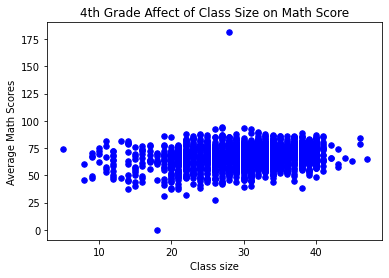

In [7]:
#This is irrelevant to the actual code and simply is there to see a graph of the classize and avgmath scores

x = df['classize']
y = df ['avgmath']

plt.scatter(x, y, color= "blue",
            s=30)
plt.xlabel('Class size')
plt.ylabel('Average Math Scores')
plt.title("4th Grade Affect of Class Size on Math Score")
plt.show()

In [8]:
#Here we actually define what our outcome, confounders and formula will be for the Backdoor Estimator. As per the feedback 
#this has been adjusted to use townid, tipuach and schoolcode.

outcome ="avgmath"
confounders = ["schlcode", "townid", "tipuach"]
formula = outcome + " ~ + {}".format(" + ".join(confounders))



In [9]:
#Here we calculate backdoor estimator but we do with MICE so that we can account for missing data. The imp.next_sample() 
#generates new data(imputations) for missing data each time. Hence, we are doing this 10 times to take an average of 
#backdoor estimator on each of the generated samples to allow for more robust findings. The standard deviation is also 
#calculated as an extra means of evaluating the backdoor estimator results. Robust meaning less likely to have occurred by 
#chance and perhaps showing the actual relation between the presented variables. 

#estimator.backdoorfeedback is different here as it is adjusted to take only two class sizes 25 and 52.

main_df = df

imp2 = mice.MICEData(main_df)
dict_estimators = defaultdict(list)
for j in range(10):
    df = imp2.next_sample()
    array_ = estimator.backdoorfeedback(df, confounders=confounders,intervention="classize", outcome="avgmath")
#     print(len(array_))
    for array_estimate in range(len(array_)):
        dict_estimators[array_estimate].append(array_[array_estimate])
    
        
ret = []
stds= []
keys = sorted(dict_estimators.keys())
for key in keys:
    backdoor_estimates = dict_estimators[key]
    avg = np.mean(backdoor_estimates)
    std = np.std(backdoor_estimates)
    stds.append(std)
    ret.append(avg)

# ret = np.array(ret)
ret_str = [float("{:.3f}".format(r)) for r in ret]
print(f'Back Door Estimates: {ret_str}')


print(f'Standard Deviations: {stds}')

Back Door Estimates: [66.125, 67.388]
Standard Deviations: [0.022989003393203658, 0.009684754489394947]


In [10]:

#This is the place we actually run the estimator.bootstrap to see the uncertainty of the data. We have combined this wiht 
#mice here to allow for viewing the uncertainty that mice would provide as that is the method being used for 
#missing data. This has also bee repeated 1 total of 100 times due to it being 10*10 to allow for more robust findings. 


def backdoor_mice(data, n_mice=10):
    imp = mice.MICEData(data)#datset with no missing data
    dict_mice = defaultdict(list)
    for j in range(n_mice):
        df = imp.next_sample()
        array_ = estimator.backdoorfeedback(df, confounders=confounders,intervention="classize", outcome="avgmath")
        for array_estimate in range(len(array_)):
            dict_mice[array_estimate].append(array_[array_estimate])
    ret = []
    keys = sorted(dict_mice.keys())
   
    for key in keys:
        backdoor_estimates = dict_mice[key]
        avg = np.mean(backdoor_estimates)
        ret.append(avg)
    return ret
# backdoor_mice(main_df)
estimator.bootstrap(main_df, backdoor_mice, n=10, n_mice=10) #n_mice*n = number of times backdoor mice runs


    
    

array([[65.10758534, 66.98901431],
       [66.79143261, 67.83731015]])

In [11]:
#produces complete datasets
# imp.next_sample()

In [25]:
#imp.next_sample() #genearates new data(imputations) for missing data each time